In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BULDING DATASET

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [15]:
def combined_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
    
        # Get Coreset samples
        coreset_samples = get_coreset_samples(model, farthest_point, dataloader, dataset, device, target_samples)
        coreset_samples = [remaining_indices[i] for i in coreset_samples]
        accelerator.print(f"Got {len(coreset_samples)} samples from coreset")
        
        # Get Least Confidence samples
        mc_indices = get_monte_carlo_samples(model, dataloader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(coreset_samples).union(set(mc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_coreset_samples(model, farthest_point, dataloader, dataset, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    farthest_data = dict(farthest_point)
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
    
    min_distances = distance_matrix[selected_indices]
    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
    farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    return sorted_dist[:n_samples]

def get_monte_carlo_samples(model, dataloader, device, n_samples):
    model.train()

    confidences = []
    # Calculate uncertainties
    for data in dataloader:
        batch_probs = []
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)

        for _ in range(3):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = 'netifier-mc-coreset'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5264, Accuracy: 0.8178, F1 Micro: 0.2611, F1 Macro: 0.177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3582, Accuracy: 0.8225, F1 Micro: 0.4021, F1 Macro: 0.2983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3254, Accuracy: 0.8409, F1 Micro: 0.5601, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2703, Accuracy: 0.8645, F1 Micro: 0.6785, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2195, Accuracy: 0.878, F1 Micro: 0.6842, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.8827, F1 Micro: 0.7307, F1 Macro: 0.7198
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.8827, F1 Micro: 0.7108, F1 Macro: 0.6975
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.8864, F1 Micro: 0.7243, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.8834, F1 Micro: 0.7384, F1 Macro: 0.7351
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5304, Accuracy: 0.8269, F1 Micro: 0.5554, F1 Macro: 0.5207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3894, Accuracy: 0.853, F1 Micro: 0.6382, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3115, Accuracy: 0.8545, F1 Micro: 0.6583, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2618, Accuracy: 0.8878, F1 Micro: 0.7381, F1 Macro: 0.7343
Epoch 5/10, Train Loss: 0.2144, Accuracy: 0.8838, F1 Micro: 0.6837, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.176, Accuracy: 0.8917, F1 Micro: 0.7442, F1 Macro: 0.7379
Epoch 7/10, Train Loss: 0.1418, Accuracy: 0.892, F1 Micro: 0.7321, F1 Macro: 0.723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.8927, F1 Micro: 0.7517, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.8966, F1 Micro: 0.7564, F1 Macro: 0.7508
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.492, Accuracy: 0.8408, F1 Micro: 0.5843, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3488, Accuracy: 0.8712, F1 Micro: 0.6451, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2758, Accuracy: 0.8859, F1 Micro: 0.727, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.8916, F1 Micro: 0.7287, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1948, Accuracy: 0.895, F1 Micro: 0.7344, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.8931, F1 Micro: 0.7491, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.8978, F1 Micro: 0.753, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.898, F1 Micro: 0.754, F1 Macro: 0.7472
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.8972, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.8384, F1 Micro: 0.5372, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3567, Accuracy: 0.8761, F1 Micro: 0.7132, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2869, Accuracy: 0.8884, F1 Micro: 0.7505, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2349, Accuracy: 0.8994, F1 Micro: 0.7561, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1874, Accuracy: 0.892, F1 Micro: 0.7603, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9025, F1 Micro: 0.7659, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9009, F1 Micro: 0.7711, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9008, F1 Micro: 0.7661, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9023, F1 Micro: 0.7621, F1 Macro: 0.7498
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8372, F1 Micro: 0.6456, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3333, Accuracy: 0.88, F1 Micro: 0.6757, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.8931, F1 Micro: 0.7264, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2187, Accuracy: 0.9005, F1 Micro: 0.7491, F1 Macro: 0.7444
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.8975, F1 Micro: 0.7479, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.8981, F1 Micro: 0.7731, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9017, F1 Micro: 0.7609, F1 Macro: 0.7501
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9016, F1 Micro: 0.7556, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9009, F1 Micro: 0.7763, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0494, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.8656, F1 Micro: 0.6325, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3182, Accuracy: 0.8897, F1 Micro: 0.7429, F1 Macro: 0.7369
Epoch 3/10, Train Loss: 0.2609, Accuracy: 0.8969, F1 Micro: 0.7347, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.8988, F1 Micro: 0.7525, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.8991, F1 Micro: 0.7588, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.8958, F1 Micro: 0.7674, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.8981, F1 Micro: 0.7606, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.8994, F1 Micro: 0.7538, F1 Macro: 0.7446
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9006, F1 Micro: 0.7604, F1 Macro: 0.7501
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.8964, F1 Micro: 0.7661, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4649, Accuracy: 0.8695, F1 Micro: 0.6554, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3129, Accuracy: 0.8891, F1 Micro: 0.7429, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.8994, F1 Micro: 0.7534, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.9022, F1 Micro: 0.7737, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9034, F1 Micro: 0.7801, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9019, F1 Micro: 0.7601, F1 Macro: 0.7445
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9019, F1 Micro: 0.7639, F1 Macro: 0.7499
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9005, F1 Micro: 0.7713, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.8983, F1 Micro: 0.7666, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.8984, F1 Micro: 0.767, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.8652, F1 Micro: 0.6769, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3128, Accuracy: 0.8884, F1 Micro: 0.7551, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2663, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7631
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.9039, F1 Micro: 0.7646, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9031, F1 Micro: 0.7692, F1 Macro: 0.7634
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9025, F1 Micro: 0.7714, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.8975, F1 Micro: 0.7675, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9048, F1 Micro: 0.7694, F1 Macro: 0.7607
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9008, F1 Micro: 0.7665, F1 Macro: 0.7579
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.8994, F1 Micro: 0.7613, F1 Macro: 0.7527

 Iteration 3711: Accuracy: 0.9019, F1 Micro: 0.772

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8684, F1 Micro: 0.6851, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.299, Accuracy: 0.8938, F1 Micro: 0.7534, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9014, F1 Micro: 0.7705, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9033, F1 Micro: 0.7707, F1 Macro: 0.762
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9008, F1 Micro: 0.7633, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9017, F1 Micro: 0.7712, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9034, F1 Micro: 0.778, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.902, F1 Micro: 0.7724, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9044, F1 Micro: 0.7732, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.44, Accuracy: 0.8641, F1 Micro: 0.6956, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.893, F1 Micro: 0.7466, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9019, F1 Micro: 0.7628, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9016, F1 Micro: 0.7672, F1 Macro: 0.7615
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.8995, F1 Micro: 0.7582, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9017, F1 Micro: 0.7638, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9041, F1 Micro: 0.7672, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9025, F1 Micro: 0.7807, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9067, F1 Micro: 0.7819, F1 Macro: 0.775
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4341, Accuracy: 0.8788, F1 Micro: 0.6881, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.9009, F1 Micro: 0.7506, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9041, F1 Micro: 0.7753, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9014, F1 Micro: 0.7802, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9023, F1 Micro: 0.7728, F1 Macro: 0.7682
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.8964, F1 Micro: 0.7636, F1 Macro: 0.7602
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.8997, F1 Micro: 0.7736, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9013, F1 Micro: 0.7767, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9019, F1 Micro: 0.7684, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9036, F1 Micro: 0.7805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4294, Accuracy: 0.8778, F1 Micro: 0.6985, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.8972, F1 Micro: 0.7511, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.9048, F1 Micro: 0.7696, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9, F1 Micro: 0.7862, F1 Macro: 0.7894
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.905, F1 Micro: 0.7645, F1 Macro: 0.7537
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9009, F1 Micro: 0.7753, F1 Macro: 0.7701
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9031, F1 Micro: 0.7786, F1 Macro: 0.7703
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.902, F1 Micro: 0.779, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9017, F1 Micro: 0.7712, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.902, F1 Micro: 0.7765, F1 Macro: 0.7739

 Iteration 4530: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4181, Accuracy: 0.8848, F1 Micro: 0.7241, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.8984, F1 Micro: 0.7732, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9031, F1 Micro: 0.776, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9056, F1 Micro: 0.7861, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9042, F1 Micro: 0.7825, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9066, F1 Micro: 0.7788, F1 Macro: 0.7756
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9047, F1 Micro: 0.7757, F1 Macro: 0.7721
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9044, F1 Micro: 0.7653, F1 Macro: 0.7591
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9039, F1 Micro: 0.7777, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9053, F1 Micro: 0.7808, F1 Macro: 0.777

 Iteration 4663: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8775, F1 Micro: 0.7346, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.8989, F1 Micro: 0.7715, F1 Macro: 0.7657
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9009, F1 Micro: 0.7636, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9069, F1 Micro: 0.7748, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9072, F1 Micro: 0.7765, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9028, F1 Micro: 0.775, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9025, F1 Micro: 0.7857, F1 Macro: 0.7841
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9045, F1 Micro: 0.7895, F1 Macro: 0.7895
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9033, F1 Micro: 0.7725, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0383, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8841, F1 Micro: 0.717, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.8959, F1 Micro: 0.746, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9044, F1 Micro: 0.7839, F1 Macro: 0.7808
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9056, F1 Micro: 0.7738, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.907, F1 Micro: 0.7909, F1 Macro: 0.7901
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9044, F1 Micro: 0.7868, F1 Macro: 0.786
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9067, F1 Micro: 0.7734, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9055, F1 Micro: 0.7831, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9053, F1 Micro: 0.7774, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.7707

 Iteration 5063: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8877, F1 Micro: 0.7352, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8972, F1 Micro: 0.7444, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9019, F1 Micro: 0.7786, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9083, F1 Micro: 0.7895, F1 Macro: 0.7858
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9066, F1 Micro: 0.7833, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.907, F1 Micro: 0.7781, F1 Macro: 0.7717
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9067, F1 Micro: 0.7717, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9039, F1 Micro: 0.7843, F1 Macro: 0.784
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.8997, F1 Micro: 0.7803, F1 Macro: 0.7813
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9089, F1 Micro: 0.7876, F1 Macro: 0.7886

 Iteration 5263: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3976, Accuracy: 0.8873, F1 Micro: 0.7178, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.8989, F1 Micro: 0.759, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9034, F1 Micro: 0.767, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.8936, F1 Micro: 0.7753, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9077, F1 Micro: 0.7804, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9092, F1 Micro: 0.7983, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9025, F1 Micro: 0.7742, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9058, F1 Micro: 0.7856, F1 Macro: 0.783
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9036, F1 Micro: 0.787, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0327, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8819, F1 Micro: 0.6747, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9006, F1 Micro: 0.7648, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9034, F1 Micro: 0.7779, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9, F1 Micro: 0.7831, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9014, F1 Micro: 0.7805, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9062, F1 Micro: 0.7732, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9055, F1 Micro: 0.7737, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9006, F1 Micro: 0.7768, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9031, F1 Micro: 0.7795, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9078, F1 Micro: 0.7931, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.89, F1 Micro: 0.7224, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8956, F1 Micro: 0.7382, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9011, F1 Micro: 0.7791, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9089, F1 Micro: 0.7857, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9045, F1 Micro: 0.7826, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9052, F1 Micro: 0.7805, F1 Macro: 0.7731
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9061, F1 Micro: 0.7836, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9047, F1 Micro: 0.7814, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9016, F1 Micro: 0.7769, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9055, F1 Micro: 0.7801, F1 Macro: 0.7777

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8913, F1 Micro: 0.7422, F1 Macro: 0.7377
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.8992, F1 Micro: 0.7392, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.903, F1 Micro: 0.7823, F1 Macro: 0.7772
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9048, F1 Micro: 0.7797, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9033, F1 Micro: 0.7859, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9069, F1 Micro: 0.7807, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9108, F1 Micro: 0.7903, F1 Macro: 0.7834
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9087, F1 Micro: 0.7853, F1 Macro: 0.7796
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9073, F1 Micro: 0.7824, F1 Macro: 0.779

 Iteration 6041: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.8919, F1 Micro: 0.7267, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9016, F1 Micro: 0.7646, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9083, F1 Micro: 0.7857, F1 Macro: 0.7792
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.908, F1 Micro: 0.781, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9017, F1 Micro: 0.775, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9002, F1 Micro: 0.774, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9056, F1 Micro: 0.7714, F1 Macro: 0.7648
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9011, F1 Micro: 0.7815, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9014, F1 Micro: 0.7593, F1 Macro: 0.7522
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9047, F1 Micro: 0.7815, F1 Macro: 0.7756

 Iteration 6218: Accuracy: 0.9083, F1 Micro: 0.7857, F1 

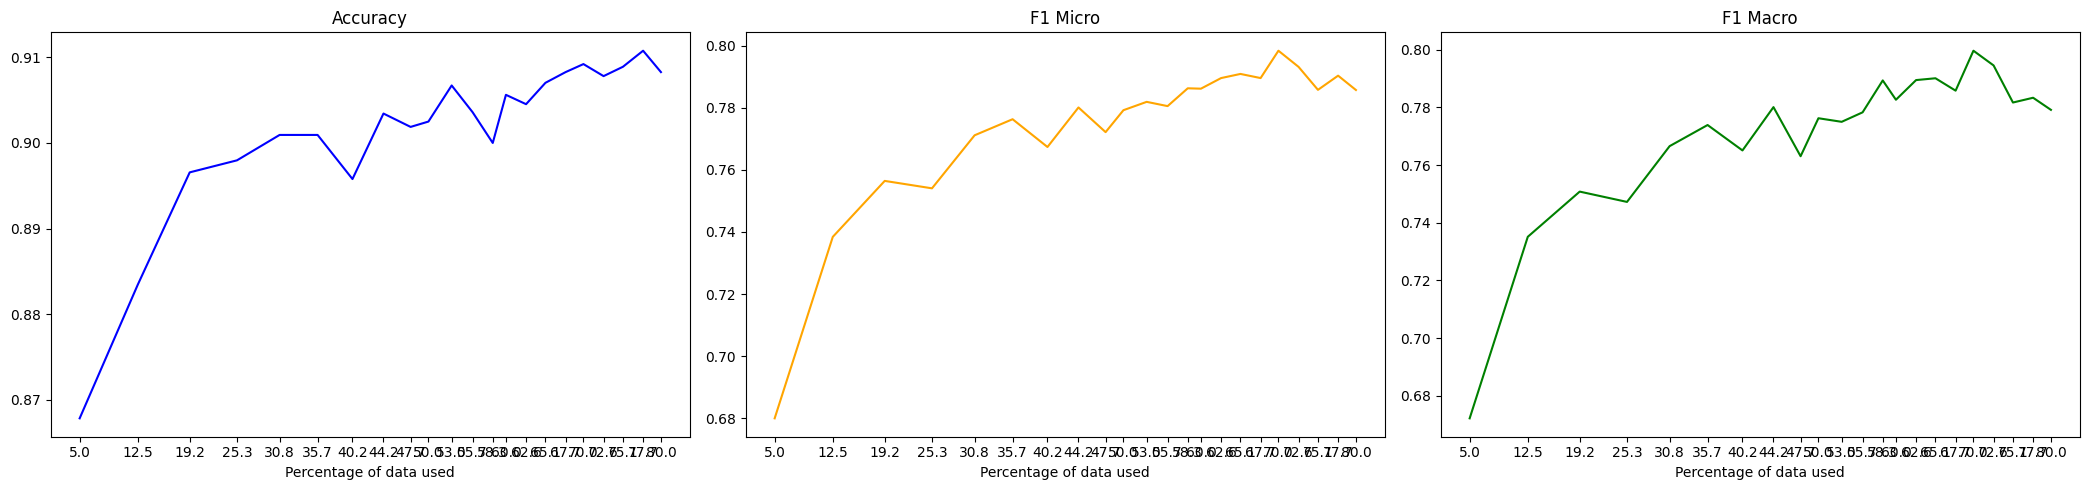

In [18]:
active_learning(seeds[0], 0)